<a href="https://colab.research.google.com/github/JaCh23/capstone_mlp/blob/master/pca_mlp_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Read the CSV file into a DataFrame

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final data/raw_sensor_values_sample_v6_new_logout_strangers_teammates.csv')

In [34]:
# Sort the DataFrame by the 'label' column in alphabetical order
df = df.sort_values(by='label')

# Reset the index and drop the old index column
df = df.reset_index(drop=True)

df.head(120)

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,label
0,-0.04,0.03,0.02,0.92,-9.87,-10.88,-0.03,0.11,0.06,0.96,...,3.60,-8.29,-1.97,0.29,-0.16,-0.11,3.27,-7.98,-4.51,G
1,-0.06,0.03,-0.03,0.86,-9.59,-9.81,-0.05,0.13,-0.01,1.19,...,4.12,-13.99,-4.38,-1.10,-0.56,1.34,6.46,-14.71,-3.88,G
2,-0.07,0.10,0.00,1.06,-9.63,-9.24,-0.07,0.10,0.02,1.02,...,3.57,-11.03,-1.93,-2.04,-0.51,0.96,1.19,-14.25,-1.64,G
3,0.00,0.05,0.01,-1.38,-9.23,-10.24,-0.14,-0.16,0.24,-0.68,...,0.96,-15.50,-3.72,-2.47,-0.16,1.77,5.98,-19.56,0.53,G
4,-0.11,0.03,-0.08,1.13,-9.52,-8.93,-0.11,0.07,-0.01,0.94,...,5.66,-8.13,3.06,-1.05,-0.40,0.51,2.84,-7.73,0.32,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.07,0.01,-0.02,1.11,-9.56,-9.06,-0.16,0.10,0.02,1.41,...,2.80,-6.71,3.10,-0.03,-0.12,0.06,3.82,-6.72,1.19,G
116,0.02,-0.02,-0.03,5.73,-7.62,-12.79,0.03,-0.05,-0.04,5.86,...,6.04,-7.54,-12.91,0.02,0.00,-0.05,5.57,-7.67,-12.87,G
117,-0.03,0.05,0.00,5.07,-7.93,-12.68,-0.01,0.03,-0.01,5.13,...,5.88,-7.42,-12.80,0.03,-0.05,-0.03,5.86,-7.16,-12.85,G
118,-0.04,0.00,-0.21,-0.32,-10.01,-10.57,0.00,-0.14,-0.15,-0.62,...,2.64,-10.00,-2.57,-0.03,-0.22,0.00,3.07,-9.72,-3.37,G


In [35]:
# find all unique values in the 'labels' column
new_df = df

# Get the count of each label
label_counts = new_df['label'].value_counts()

print(label_counts)

G    210
L    210
R    210
S    210
Name: label, dtype: int64


In [38]:
# 360 -> 90x G,L,R,S

SAMPLES_PER_LABEL = 210

test_g = new_df.iloc[1].values
test_g = test_g[:-1]

test_l = new_df.iloc[(1*SAMPLES_PER_LABEL) + 1].values
test_l = test_l[:-1]

test_r = new_df.iloc[(2*SAMPLES_PER_LABEL) + 1].values
test_r = test_r[:-1]

test_s = new_df.iloc[(3*SAMPLES_PER_LABEL) + 1].values
test_s = test_s[:-1]

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Instantiate LabelEncoder and OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()

# Encode the labels of the training set
labels_encoded = le.fit_transform(new_df.iloc[:, -1])
# Convert the encoded labels to one-hot encoding
labels_onehot = ohe.fit_transform(labels_encoded.reshape(-1, 1)).toarray()

# Print the one-hot encoding scheme and mapping
print('One-hot encoding scheme:', ohe.categories_)
print('Mapping of numerical labels to original labels:', {i:label for i, label in enumerate(le.classes_)})

One-hot encoding scheme: [array([0, 1, 2, 3])]
Mapping of numerical labels to original labels: {0: 'G', 1: 'L', 2: 'R', 3: 'S'}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense

# Split the data
X_train, X_test, y_train, y_test = train_test_split(new_df.iloc[:, :-1].astype(float), labels_onehot, test_size=0.1, random_state=42)

In [ ]:
from scipy.signal import find_peaks
from scipy.stats import skew, kurtosis

def extract_features(raw_sensor_data):

    # Apply median filtering column-wise using the rolling function, window=5
    # min_periods=1 argument allows the rolling mean to be calculated even if there are fewer than 5 rows available, by using all the available rows in window instead
    sensor_data = raw_sensor_data.rolling(5, min_periods=1, axis=0).mean()
    sensor_data = sensor_data.to_numpy()

    # Compute statistical features
    mean = np.mean(sensor_data, axis=0)
    std = np.std(sensor_data, axis=0)
    abs_diff = np.abs(np.diff(sensor_data, axis=0)).mean(axis=0)
    minimum = np.min(sensor_data, axis=0)
    maximum = np.max(sensor_data, axis=0)
    max_min_diff = maximum - minimum
    median = np.median(sensor_data, axis=0)
    mad = np.median(np.abs(sensor_data - np.median(sensor_data, axis=0)), axis=0)
    iqr = np.percentile(sensor_data, 75, axis=0) - np.percentile(sensor_data, 25, axis=0)
    negative_count = np.sum(sensor_data < 0, axis=0)
    positive_count = np.sum(sensor_data > 0, axis=0)
    values_above_mean = np.sum(sensor_data > mean, axis=0)
    
    peak_counts = np.array(np.apply_along_axis(lambda x: len(find_peaks(x)[0]), 0, sensor_data)).flatten()

    skewness = np.array(pd.DataFrame(sensor_data.reshape(-1,6)).skew().values).flatten()
    kurt = np.array(pd.DataFrame(sensor_data.reshape(-1,6)).kurtosis().values).flatten()
    energy = np.array(np.sum(sensor_data**2, axis=0)).flatten()

    # Compute the average resultant for gyro and acc columns
    gyro_cols = sensor_data[:, :3]
    acc_cols = sensor_data[:, 3:]
    gyro_avg_result = np.array(np.sqrt((gyro_cols**2).sum(axis=1)).mean()).flatten()
    acc_avg_result = np.array(np.sqrt((acc_cols**2).sum(axis=1)).mean()).flatten()

    # Compute the signal magnitude area for gyro and acc columns
    gyro_sma = np.array((np.abs(gyro_cols) / 100).sum(axis=0).sum()).flatten()
    acc_sma = np.array((np.abs(acc_cols) / 100).sum(axis=0).sum()).flatten()

    # Concatenate features and return as a list
    temp_features = np.concatenate([mean, std, abs_diff, minimum, maximum, max_min_diff, median, mad, iqr,
                                    negative_count, positive_count, values_above_mean, peak_counts, skewness, kurt, energy,
                                    gyro_avg_result, acc_avg_result, gyro_sma, acc_sma])
  
    return temp_features.tolist()

train_df = new_df

X_train_feat = []
X_test_feat = []

for i in range(X_train.shape[0]):
  row = X_train.iloc[[i], :].values.reshape(-1, 6)
  feature_vec = extract_features(pd.DataFrame(row))
  X_train_feat.append(feature_vec)

for i in range(X_test.shape[0]):
  row = X_test.iloc[[i], :].values.reshape(-1, 6)
  feature_vec = extract_features(pd.DataFrame(row))
  X_test_feat.append(feature_vec)

X_train_feat = np.array(X_train_feat)
X_test_feat = np.array(X_test_feat)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Apply StandardScaler to the sensor data
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_feat)

X_test_scaled = scaler.transform(X_test_feat)

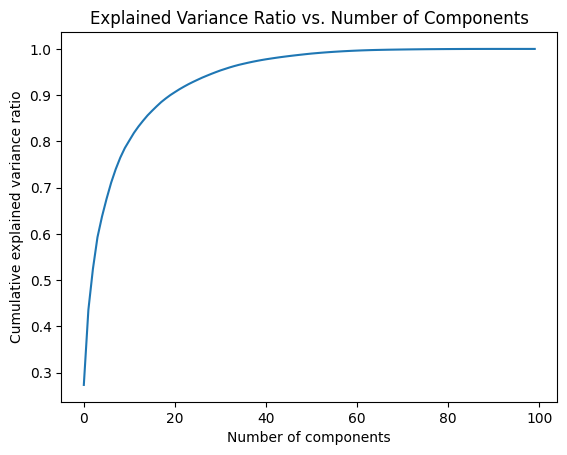

,Number of Components,Cumulative Explained Variance Ratio
0,1,0.273253
1,2,0.435517
2,3,0.524367
3,4,0.592827
4,5,0.637720
5,6,0.676029
6,7,0.710671
7,8,0.739857
8,9,0.764786
9,10,0.785510


In [ ]:
# PCA exploration

# create a PCA object
pca = PCA()

# fit the PCA object to the sensor data
X_train_pca = pca.fit_transform(X_train_scaled)

# calculate the cumulative sum of the explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# plot the cumulative sum of the explained variance ratio
plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()

# create a DataFrame to store the cumulative explained variance ratio
df_cumulative_variance_ratio = pd.DataFrame({'Number of Components': range(1, len(cumulative_variance_ratio)+1),
                                             'Cumulative Explained Variance Ratio': cumulative_variance_ratio})

# print the DataFrame
df_cumulative_variance_ratio.head(40)

In [ ]:
from sklearn.decomposition import PCA

# create a PCA object with n_components = K
pca = PCA(n_components= 24 )

# fit the PCA object to the sensor data
X_train_pca = pca.fit_transform(X_train_scaled)

X_test_pca = pca.transform(X_test_scaled)

# print the explained variance ratio for each component
print(pca.explained_variance_ratio_)

# Get the number of components needed to explain K% of the variance
n_components_needed = pca.n_components_
print("Number of components needed to explain K% of variance:", n_components_needed)

# compare top k eigenvalues and top k eigenvectors 
pca_eigvecs = pca.components_[:n_components_needed]
pca_eigvals = pca.explained_variance_[:n_components_needed]

[0.27325316 0.16226377 0.08885014 0.06845995 0.04489309 0.03830906
 0.03464184 0.02918607 0.02492842 0.0207248  0.01651393 0.01632305
 0.01387514 0.01238093 0.01167013 0.01008022 0.00960929 0.00914854
 0.0078368  0.00725901 0.00639432 0.00622025 0.00565064 0.00534956]
Number of components needed to explain K% of variance: 24


In [ ]:
# Define MLP model
model = Sequential()
model.add(Dense(16, input_dim=24, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train_pca, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
22/22 [==============================] - 2s 24ms/step - loss: 0.0768 - accuracy: 0.9912 - val_loss: 0.1694 - val_accuracy: 0.9474
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.9956 - val_loss: 0.1466 - val_accuracy: 0.9474
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0397 - accuracy: 0.9971 - val_loss: 0.1339 - val_accuracy: 0.9474
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0314 - accuracy: 0.9971 - val_loss: 0.1265 - val_accuracy: 0.9474
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0257 - accuracy: 0.9971 - val_loss: 0.1198 - val_accuracy: 0.9474
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0219 - accuracy: 0.9971 - val_loss: 0.1118 - val_accuracy: 0.9474
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 0.0187 - accuracy: 0.9971 - val_loss: 0.1083 - val_accuracy: 0.9474
Epoch 8/100


In [ ]:
# hyperparameter tuning
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

# # Define function to create model
# def create_model(nodes=120, layers=3, optimizer='adam', activation='relu'):
#     model = Sequential()
#     model.add(Dense(nodes, input_dim=X_train.shape[1], activation=activation))
#     for i in range(layers-1):
#         model.add(Dense(nodes // (2 ** i), activation=activation))
#     model.add(Dense(4, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     return model

# # Wrap Keras model for use with GridSearchCV
# keras_model = KerasClassifier(build_fn=create_model, verbose=0)

# # Define hyperparameters to search over
# param_grid = {'nodes': [64, 128, 256],
#               'layers': [2, 3, 4, 5, 6],
#               'optimizer': ['adam', 'rmsprop'],
#               'activation': ['relu', 'sigmoid']}

# # Use GridSearchCV to search over hyperparameters
# grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(X_train, y_train)

# # Print best hyperparameters and accuracy
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# hyperparameter tuning
# # Get the best hyperparameters
# best_params = grid_result.best_params_

# # Create the model with the best hyperparameters
# model = create_model(nodes=best_params['nodes'], layers=best_params['layers'],
#                      optimizer=best_params['optimizer'], activation=best_params['activation'])

# # Train the model on the data
# model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.1)

In [ ]:
# Evaluate model on testing data
# loss, accuracy = model.evaluate(X_test_pca, y_test)
# print('Test loss:', loss)
# print('Test accuracy:', accuracy)

----------------------------

In [ ]:
mean = scaler.mean_
scale = scaler.scale_
weights = [w.tolist() for w in model.get_weights()]

mean_vec = pca.mean_
# pca_eigvecs = pca.components_[:n_components_needed]

np.savez('features_v1.6.npz', mean=mean, scale=scale, mean_vec=mean_vec, pca_eigvecs=pca_eigvecs, weights_list=weights)

/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [ ]:
# Define MLP - 3 layers
def mlp_math(X):
    H1 = np.dot(X, weights[0]) + weights[1]
    H1_relu = np.maximum(0, H1)
    H2 = np.dot(H1_relu, weights[2]) + weights[3]
    H2_relu = np.maximum(0, H2)
    Y = np.dot(H2_relu, weights[4]) + weights[5]
    Y_softmax = np.exp(Y) / np.sum(np.exp(Y))
    return Y_softmax

def get_action(softmax_array):
    max_index = np.argmax(softmax_array)
    action_dict = {0: 'G', 1: 'L', 2: 'R', 3: 'S'}
    action = action_dict[max_index]
    return action

In [ ]:
# sanity check

s,c = 0,0

LOWER = 200
UPPER = LOWER+300
for ROW_NUM in range(LOWER, UPPER+1):
  sanity_df = new_df.iloc[ROW_NUM]
  sanity_label = sanity_df.iloc[-1]
  sanity_data = sanity_df[:180].values.reshape(1,-1)

  scaled_action_df = pd.DataFrame(sanity_data.reshape(-1,6))

  # 1. Feature extraction
  feature_vec = np.array(extract_features(scaled_action_df)).reshape(1,-1)

  # 2. Scaler using features
  scaled_action = scaler.transform(feature_vec)
  scaled_action_math = (feature_vec - mean) / scale

  tolerance = 1e-5
  assert np.allclose(scaled_action.astype(float), scaled_action_math.astype(float), atol=tolerance)

  # 3. PCA using scaler
  pca_vec = (pca.transform(scaled_action)).astype(float)
  pca_test_centered = scaled_action_math - mean_vec.reshape(1,-1)
  pca_vec_math = np.dot(pca_test_centered, pca_eigvecs.T).astype(float)

  assert np.allclose(pca_vec, pca_vec_math, atol=tolerance, rtol=tolerance)

  # 4. MLP using PCA
  pred = model.predict(np.array(pca_vec).reshape(1,-1))
  pred_math = mlp_math(np.array(pca_vec_math).reshape(1,-1))

  tol = 1e-2
  assert np.allclose(pred, pred_math, atol=tol, rtol=tol)

  action = get_action(pred)
  action_math = get_action(pred_math)

  assert action == action_math

  if sanity_label == action_math:
    s += 1

  c +=1

  print(action, action_math, sanity_label)

print(s)
print(c)
print(s*100/c)

In [ ]:
# # jupyter side sanity case checker

# def test_case_checker(test_case):
#   sanity_data = test_case.reshape(1,-1)

#   scaled_action_df = pd.DataFrame(sanity_data.reshape(-1,6))

#   # 1. Feature extraction
#   feature_vec = np.array(extract_features(scaled_action_df)).reshape(1,-1)

#   # 2. Scaler using features
#   scaled_action = scaler.transform(feature_vec)
#   scaled_action_math = (feature_vec - mean) / scale

#   tolerance = 1e-5
#   assert np.allclose(scaled_action.astype(float), scaled_action_math.astype(float), atol=tolerance)

#   # 3. PCA using scaler
#   pca_vec = (pca.transform(scaled_action)).astype(float)
#   pca_test_centered = scaled_action_math - mean_vec.reshape(1,-1)
#   pca_vec_math = np.dot(pca_test_centered, pca_eigvecs.T).astype(float)

#   assert np.allclose(pca_vec, pca_vec_math, atol=tolerance, rtol=tolerance)

#   # 4. MLP using PCA
#   pred = model.predict(np.array(pca_vec).reshape(1,-1))
#   pred_math = mlp_math(np.array(pca_vec_math).reshape(1,-1))

#   tol = 1e-2
#   assert np.allclose(pred, pred_math, atol=tol, rtol=tol)

#   action = get_action(pred)
#   action_math = get_action(pred_math)

#   assert action == action_math

#   print(pred_math)
#   print(action_math)

# test_case = test_s
# test_case_checker(test_case)

1/1 [==============================] - 0s 21ms/step
[[4.70722915e-06 5.66195865e-05 4.53160321e-06 9.99934142e-01]]
S


In [50]:
# sanity case checker to compare with cpp code

def test_case_checker(test_case):
  sanity_data = test_case.reshape(1,-1)

  scaled_action_df = pd.DataFrame(sanity_data.reshape(-1,6))

  # 1. Feature extraction
  feature_vec = np.array(extract_features(scaled_action_df)).reshape(1,-1)

  demo = feature_vec.reshape(-1,1)

  with open('test_data.txt', 'w') as f:
    # Write mean
    f.write('float test_s[] = {')
    for i in range(len(demo)):
        f.write('%.16f' % demo[i])
        if i != len(demo) - 1:
            f.write(', ')
    f.write('};\n\n')

  # 2. Scaler using features
  scaled_action_math = (feature_vec - mean) / scale

  # 3. PCA using scaler
  pca_test_centered = scaled_action_math - mean_vec.reshape(1,-1)
  pca_vec_math = np.dot(pca_test_centered, pca_eigvecs.T).astype(float)

  # 4. MLP using PCA
  pred_math = mlp_math(np.array(pca_vec_math).reshape(1,-1))
  action_math = get_action(pred_math)

  print(pred_math)
  print(action_math)

test_case = test_s
test_case_checker(test_case)

[[2.17604117e-06 5.88488803e-06 2.44145699e-08 9.99991915e-01]]
S


In [ ]:
# downloading to vivado
# reset computer runtime and run these files

In [39]:
features = np.load('/content/features_v1.6.npz', allow_pickle=True)

pca_eigvecs = features['pca_eigvecs']
weights = features['weights_list']
mean_vec = features['mean_vec']
scale = features['scale']
mean = features['mean']

In [40]:
# # bitstream tools

# Chop all values to 16 decimal places
pca_eigvecs = np.round(pca_eigvecs, decimals=16)
mean_vec = np.round(mean_vec, decimals=16)
scale = np.round(scale, decimals=16)
mean = np.round(mean, decimals=16)
weights = [np.round(w, decimals=16) for w in weights]

In [41]:
# Write the arrays to an output file
with open('arrays_new.txt', 'w') as f:
    # Write mean_vec
    f.write('float mean_vec[] = {')
    for i in range(len(mean_vec)):
        f.write('%.16f' % mean_vec[i])
        if i != len(mean_vec) - 1:
            f.write(', ')
    f.write('};\n\n')

    # Write mean
    f.write('float mean[] = {')
    for i in range(len(mean)):
        f.write('%.16f' % mean[i])
        if i != len(mean) - 1:
            f.write(', ')
    f.write('};\n\n')

    # Write scale
    f.write('float scale[] = {')
    for i in range(len(scale)):
        f.write('%.16f' % scale[i])
        if i != len(scale) - 1:
            f.write(', ')
    f.write('};\n\n')

    # Write PCA eigenvectors
    f.write('float pca_eigvecs[] = {')
    for i in range(len(pca_eigvecs)):
        for j in range(len(pca_eigvecs[i])):
            f.write('%.16f' % pca_eigvecs[i][j])
            if i != len(pca_eigvecs) - 1 or j != len(pca_eigvecs[i]) - 1:
                f.write(', ')
    f.write('};\n\n')

    # Write weights
    for k, w in enumerate(weights):
      if k in [0, 2, 4]:
          # Two-dimensional weight matrix
          rows, cols = w.shape
          f.write('float w%d[%d][%d] = {\n' % (k, rows, cols))
          for i in range(rows):
              f.write('\t{')
              for j in range(cols):
                  f.write('%.16f' % w[i][j])
                  if j != cols - 1:
                      f.write(', ')
              f.write('}')
              if i != rows - 1:
                  f.write(',')
              f.write('\n')
          f.write('};\n\n')
      else:
          # One-dimensional weight vector
          f.write('float w%d[] = {' % k)
          for i in range(len(w)):
              f.write('%.16f' % w[i])
              if i != len(w) - 1:
                  f.write(', ')
          f.write('};\n\n')